# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log2/")
print(LOG_PATH)


/Users/rco/github/s_metaheuristic/data/log2


In [43]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [44]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [45]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [46]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [47]:
all_dfs = []
best_dfs = []
LOGs = str(LOG_PATH) + '/*.csv'

c = 0
for file in glob.glob(str(LOGs)):
    filename = file[file.find('/log/')+5:]
    try:
        df = pd.read_csv(file, low_memory=False, sep=',', quotechar='"')
        c = c + 1
    except:
        print('Arquivo não importado: {}'.format(filename))
    df['filename'] = filename
    df['Z'] = df.Z.apply(lambda x: literal_eval(x))
    df['X'] = df.X.apply(lambda x: literal_eval(x))
    df['k'] = df.Z.apply(lambda x: len(x))
    df.reset_index(drop=False, inplace=True)
    all_dfs.append(df)
    best_dfs.append(df.iloc[-1:])

all_data = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
all_data.rename({'move_strategy':'move_str',
                 'selection_strategy':'selec_str'}, axis=1, inplace=True)

best_data = pd.concat(best_dfs, ignore_index=True).reset_index(drop=True)
best_data.rename({'move_strategy':'move_str',
                  'selection_strategy':'selec_str'}, axis=1, inplace=True)

print('Importados {} arquivos'.format(c))

# for col in all_data.columns:
#     all_data[col] = pd.to_numeric(all_data[col])

# for col in best_data.columns:
#     best_data[col] = pd.to_numeric(best_data[col])

Importados 2 arquivos


In [48]:
all_data.Z

0         [12, 14, 15, 18, 23, 27]
1         [12, 14, 15, 18, 23, 27]
2         [12, 14, 15, 18, 23, 27]
3         [12, 14, 15, 18, 23, 27]
4         [12, 14, 15, 18, 23, 27]
                   ...            
2469    [4, 8, 12, 16, 18, 25, 28]
2470    [4, 8, 12, 16, 18, 25, 28]
2471    [4, 8, 12, 16, 18, 25, 28]
2472    [4, 8, 12, 16, 18, 25, 28]
2473    [4, 8, 12, 16, 18, 25, 28]
Name: Z, Length: 2474, dtype: object

In [49]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474 entries, 0 to 2473
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        2474 non-null   int64  
 1   iter         2474 non-null   int64  
 2   move         2474 non-null   object 
 3   improve      2474 non-null   bool   
 4   obj          2474 non-null   float64
 5   return       2474 non-null   float64
 6   n_assets     2474 non-null   int64  
 7   qX           2474 non-null   int64  
 8   qN           2474 non-null   int64  
 9   qNv          2474 non-null   int64  
 10  iter_time    2474 non-null   float64
 11  max_iter     2474 non-null   int64  
 12  neighbours   2474 non-null   int64  
 13  alpha        2474 non-null   float64
 14  exp_return   2474 non-null   float64
 15  k_min        2474 non-null   int64  
 16  k_max        2474 non-null   int64  
 17  move_str     2474 non-null   object 
 18  selec_str    2474 non-null   object 
 19  tag   

In [50]:
# all_data.describe(include='all').T

## Portfólios

### Geral

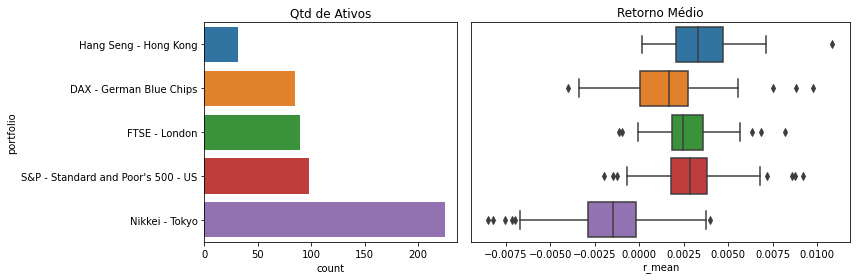

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

### Matriz de Covariância

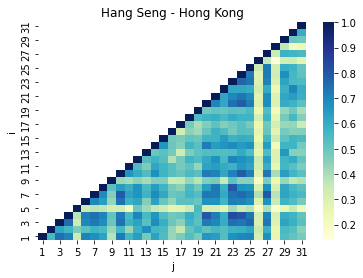

In [52]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [53]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


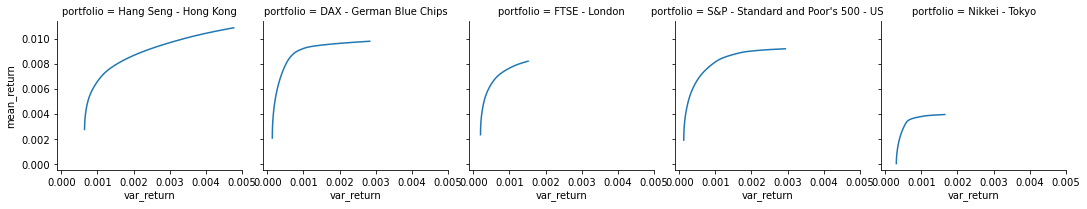

In [54]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

### Avaliação do Impacto da Seed

In [55]:
all_data.describe().T

,count,mean,std,min,25%,50%,75%,max
index,2474.0,618.363783,3.577927e+02,0.00000,309.000000,618.000000,927.000000,1266.000000
iter,2474.0,9.127728,1.492959e+01,0.00000,3.000000,6.000000,9.000000,99.000000
obj,2474.0,0.024951,1.755386e-02,0.00788,0.008770,0.033627,0.035132,0.121640
return,2474.0,0.005682,4.665007e-03,0.00100,0.001002,0.006304,0.010539,0.010573
n_assets,2474.0,6.020614,9.981683e-01,5.00000,5.000000,7.000000,7.000000,8.000000
qX,2474.0,6.020614,9.981683e-01,5.00000,5.000000,7.000000,7.000000,8.000000
qN,2474.0,1000.000000,0.000000e+00,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
qNv,2474.0,397.449070,2.945172e+02,47.00000,224.000000,245.000000,608.000000,1000.000000
iter_time,2474.0,0.352407,1.691046e-01,0.14569,0.194292,0.231948,0.515777,0.679321
max_iter,2474.0,100.000000,0.000000e+00,100.00000,100.000000,100.000000,100.000000,100.000000


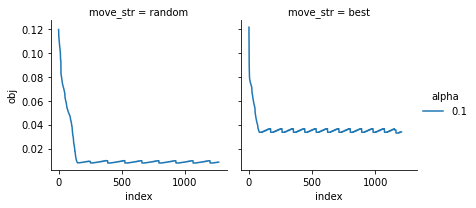

In [56]:
g = sns.FacetGrid(
    data=all_data, col='move_str', hue='alpha')
g.map(sns.lineplot, 'index', 'obj')
g.add_legend()
g=g

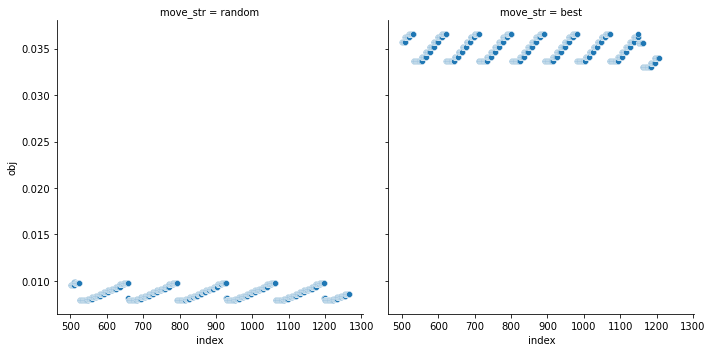

In [65]:
sns.relplot(data=data, x='index', y='obj', col='move_str')

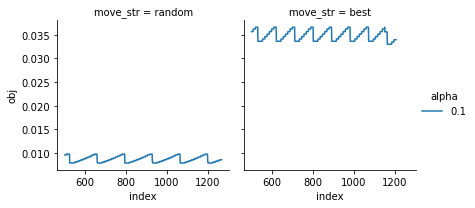

In [64]:
data = all_data[all_data['index']>500]
g = sns.FacetGrid(
    data=data, col='move_str', hue='alpha')
g.map(sns.lineplot, 'index', 'obj')
g.add_legend()
g=g

In [24]:
# g = sns.FacetGrid(
#     data=all_data, row='seed', col='selec_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Tipo de Move

In [16]:
# g = sns.FacetGrid(
#     data=all_data, row='selec_str', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Impacto do Retorno Experado

In [17]:
# g = sns.FacetGrid(
#     data=all_data, row='exp_return', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

## Análise Best - Portfólio 1

In [18]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [19]:
print(best_data.shape)
best_data.head()

(1, 25)


,iter,move,improve,obj,return,n_assets,qX,qN,qNv,iter_time,...,k_max,move_str,selec_str,tag,X,Z,gls_iter,gls_improve,filename,k
0,10,idID,False,0.00858,0.010539,5,5,1000,48,0.161437,...,15,random,random,gls,"[0.959024, 0.010011, 0.010344, 0.010621, 0.01]","[4, 10, 25, 27, 30]",99,False,rs/rco/github/s_metaheuristic/data/log2/log_gl...,5


In [20]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,1.0,10.000000,NaN,10.000000,10.000000,10.000000,10.000000,10.000000
obj,1.0,0.008580,NaN,0.008580,0.008580,0.008580,0.008580,0.008580
return,1.0,0.010539,NaN,0.010539,0.010539,0.010539,0.010539,0.010539
n_assets,1.0,5.000000,NaN,5.000000,5.000000,5.000000,5.000000,5.000000
qX,1.0,5.000000,NaN,5.000000,5.000000,5.000000,5.000000,5.000000
qN,1.0,1000.000000,NaN,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
qNv,1.0,48.000000,NaN,48.000000,48.000000,48.000000,48.000000,48.000000
iter_time,1.0,0.161437,NaN,0.161437,0.161437,0.161437,0.161437,0.161437
max_iter,1.0,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000
neighbours,1.0,1000.000000,NaN,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


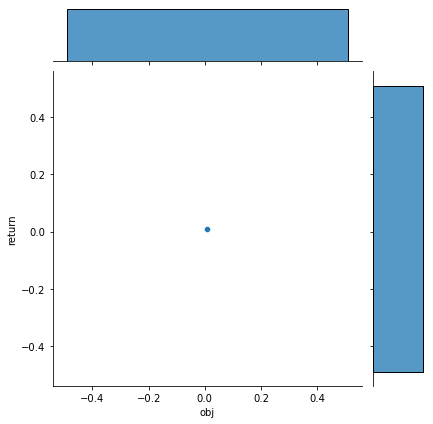

In [21]:
sns.jointplot(data=best_data, x='obj', y='return', palette='bright')

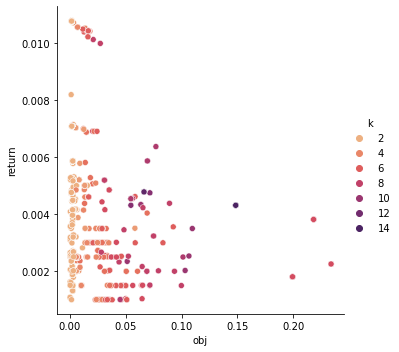

In [22]:
sns.relplot(data=best_data, x='obj', y='return', hue='k', palette='flare')

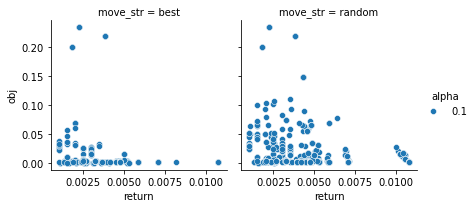

In [23]:
g = sns.FacetGrid(data=best_data, col='move_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

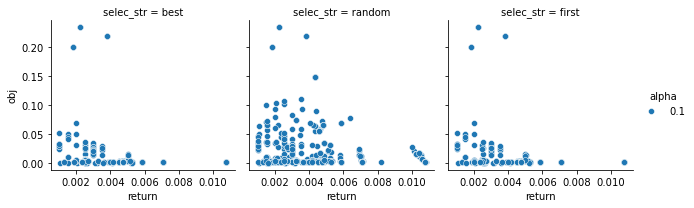

In [24]:
g = sns.FacetGrid(data=best_data, col='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

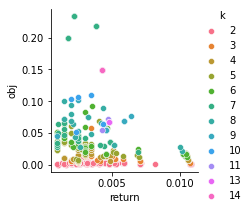

In [25]:
g = sns.FacetGrid(data=best_data, hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

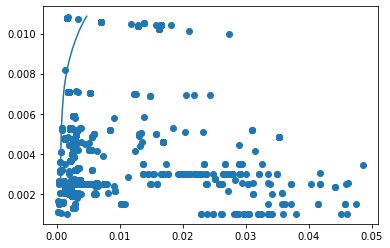

In [26]:
data = best_data[best_data['obj']<0.05]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])

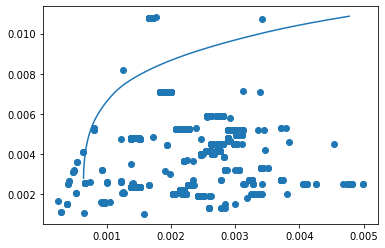

In [27]:
data = best_data[best_data['obj']<0.005]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])

In [28]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.0010  0.0015  0.0020  0.0025  0.0030  0.0035  0.0040  \
move_str selec_str                                                           
best     best           95      95      93      88      85      60      42   
         first          95      95      93      88      77      60      42   
         random         95      95      93      88      77      60      42   
random   best           95      95      93      88      77      60      42   
         first          95      95      93      88      77      60      42   
         random         95      95      93      88      77      60      42   

exp_return          0.0045  0.0050  0.0055  0.0060  0.0065  0.0070  0.0075  \
move_str selec_str                                                           
best     best           25      17      12       9       9       7       5   
         first          25      17      12       9       9       7       5   
         random         25      17      12       9       9       7       5   
random   best           25      17      12       9       9       7       5   
         first          25      17      12       9       9       7       5   
         random         25      17      12       9       9       7       5   

exp_return          0.0080  
move_str selec_str          
best     best            1  
         first           1  
         random          1  
random   best            1  
         first           1  
         random          1

In [29]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return            0.0010    0.0015    0.0020    0.0025    0.0030  \
move_str selec_str                                                     
best     best       0.000293  0.000386  0.000532  0.000416  0.000473   
         first      0.000293  0.000386  0.000532  0.000416  0.000473   
         random     0.000648  0.000383  0.001235  0.000662  0.000487   
random   best       0.001380  0.001380  0.001380  0.000405  0.001381   
         first      0.001380  0.001380  0.001380  0.000405  0.001381   
         random     0.000978  0.000247  0.001381  0.001220  0.001381   

exp_return            0.0035    0.0040    0.0045    0.0050    0.0055  \
move_str selec_str                                                     
best     best       0.000547  0.000626  0.001383  0.001653  0.001654   
         first      0.000547  0.000626  0.001383  0.001653  0.001654   
         random     0.001381  0.001380  0.001381  0.001258  0.001654   
random   best       0.001381  0.001381  0.001381  0.001654  0.001654   
         first      0.001381  0.001381  0.001381  0.001654  0.001654   
         random     0.001381  0.001381  0.001381  0.001654  0.001654   

exp_return            0.0060    0.0065    0.0070    0.0075    0.0080  
move_str selec_str                                                    
best     best       0.001655  0.001655  0.001655  0.001655  0.001718  
         first      0.001655  0.001655  0.001655  0.001655  0.001718  
         random     0.001654  0.001654  0.001654  0.001654  0.001655  
random   best       0.001654  0.001654  0.001654  0.001654  0.001654  
         first      0.001654  0.001654  0.001654  0.001654  0.001654  
         random     0.001654  0.001654  0.001654  0.001655  0.001655

In [30]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(15, 2)


,exp_return,obj
0,0.0010,0.000293
1,0.0015,0.000247
2,0.0020,0.000532
3,0.0025,0.000405
4,0.0030,0.000473


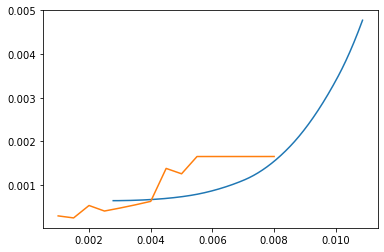

In [31]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)